# Série temporal em dados de vendas de Shampoo

In [ ]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

Conjunto de dados de venda de Shampoo, estacionários?

In [ ]:
df_shampoo = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv')
df_shampoo.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


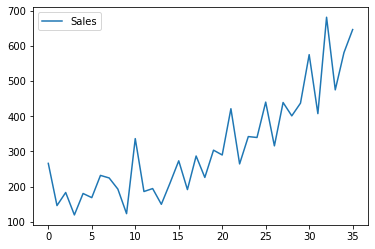

In [ ]:
df_shampoo.plot()

In [ ]:
rolmean = df_shampoo['Sales'].rolling(window=12).mean()
rolstd = df_shampoo['Sales'].rolling(window=12).std()

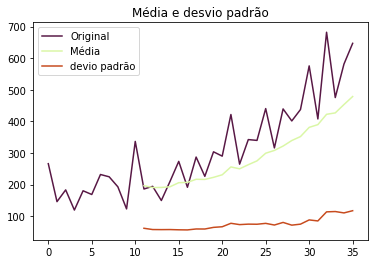

<Figure size 1152x1152 with 0 Axes>

In [ ]:

#Plot statistics:
plt.plot(df_shampoo['Sales'], color= '#581845',label='Original')
plt.plot(rolmean, color='#DAF7A6', label='Média')
plt.plot(rolstd, color= '#c74b1e', label = 'devio padrão')
plt.legend(loc='best')
plt.title('Média e desvio padrão')
plt.figure(figsize=(16,16))
plt.show()

[statsmodels](https://www.statsmodels.org/devel/index.html) é um módulo Python que fornece classes e funções para a estimativa de muitos modelos estatísticos diferentes, bem como para a realização de testes estatísticos e a exploração de dados estatísticos.
Função **Augmented Dickey-Fuller unit root test** [adfuller](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.adfuller.html)


In [ ]:
from statsmodels.tsa.stattools import adfuller
adfuller_test = adfuller(df_shampoo['Sales'].values)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def describe_adfuller_test_result(result):
  return f"""test statistic: {result[0]} 
    pvalue: {round(result[1], 4)}
    usedlag: {result[2]}
    nobs: {result[3]}
    critical values: {result[4]}
    icbest: {result[5]} """
print(describe_adfuller_test_result(adfuller_test))

test statistic: 3.0601420836411823 
    pvalue: 1.0
    usedlag: 10
    nobs: 25
    critical values: {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}
    icbest: 278.9972644263031 


In [ ]:
def train_test_split(data):
    data = data.values
    scores = []
    # data split
    n_test = int(len(data)*0.2) # 20% test
    n_train = len(data) - n_test
    print("Tamanho treino %s " % n_train)
    print("Tamanho test %s " % n_test)
    return data[:-n_test], data[-n_test:]
train, test = train_test_split(df_shampoo['Sales'])

Tamanho treino 29 
Tamanho test 7 


Mean squared error [MRS](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

```
from sklearn.metrics import mean_squared_error
```



In [ ]:
# metrica root mean squared error
from sklearn.metrics import mean_squared_error
def metrica_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [ ]:
def display(data, train, y_pred):
  pred = pd.DataFrame(list(train.flatten())+ y_pred)
  ax = data.plot(label="Original") # main data
  pred.plot(ax=ax, alpha=.7, figsize=(14,7))
  plt.show()

## Predição por Média 

In [ ]:
# para grid_search
def simple_configs(max_length, offsets=[1]):
    configs = []
    for i in range(1, max_length+1):
        for t in ['median',"mean"]:
            cfg = [i, t]
            configs.append(cfg)
    return configs
cfg = simple_configs(len(train))[1]

In [ ]:
# one-step average forecast
def average_forecast(history, config):
    n, avg_type = config
    if avg_type is 'mean':
        return np.mean(history[-n:])
    return np.median(history[-n:])

rmse: 161.30044725825866


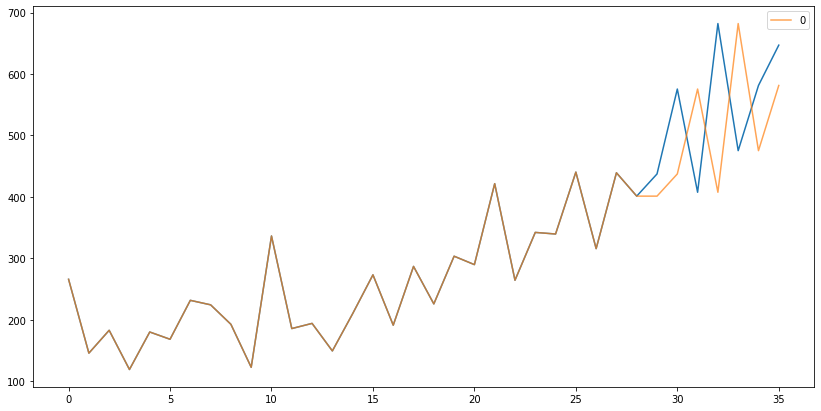

In [ ]:
history = [x for x in train]    
predictions = [ ]
cfg = 1, 'mean'
for i in range(len(test)):
    pred_y = average_forecast(history, cfg)
    predictions.append(pred_y)
    history.append(test[i])

error = metrica_rmse(test, predictions)
print(f'rmse: {error}')
display(df_shampoo['Sales'], train, predictions)

rmse: 161.30044725825866


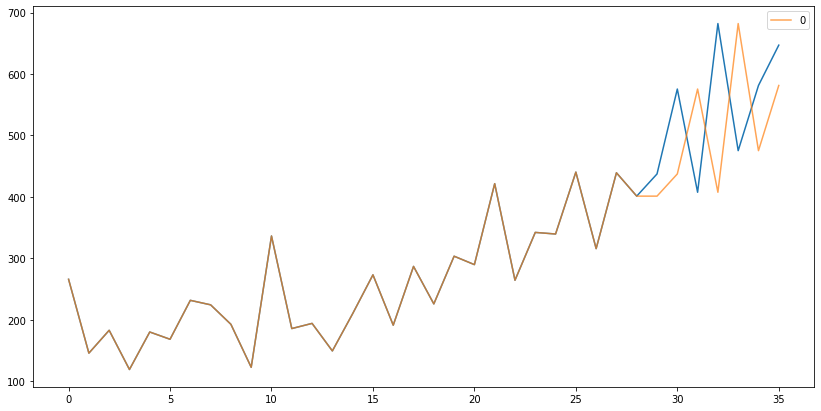

In [ ]:
history = [x for x in train]    
predictions = [ ]
cfg = 1, 'median'
for i in range(len(test)):
    pred_y = average_forecast(history, cfg)
    predictions.append(pred_y)
    history.append(test[i])

error = metrica_rmse(test, predictions)
print(f'rmse: {error}')
display(df_shampoo['Sales'], train, predictions)

# Sarima

Modelo Sarima [Sarimax](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

`from statsmodels.tsa.statespace.sarimax import SARIMAX`

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
def sarima_configs(seasonal=[0]):
  models = list()
  
  # define config lists
  p_params = [0, 1, 2]
  d_params = [0, 1]
  q_params = [0, 1, 2]
  t_params = ['n','c','t','ct'] 
  P_params = [0, 1, 2]
  D_params = [0, 1]
  Q_params = [0, 1, 2]
  m_params = seasonal
  
  # create config instances
  for p in p_params:
      for d in d_params:
          for q in q_params:
              for t in t_params:
                  for P in P_params:
                      for D in D_params:
                          for Q in Q_params:
                              for m in m_params:
                                  cfg = [(p,d,q), (P,D,Q,m), t]
                                  models.append(cfg)
  return models
list_models = sarima_configs()
list_models

[[(0, 0, 0), (0, 0, 0, 0), 'n'],
 [(0, 0, 0), (0, 0, 1, 0), 'n'],
 [(0, 0, 0), (0, 0, 2, 0), 'n'],
 [(0, 0, 0), (0, 1, 0, 0), 'n'],
 [(0, 0, 0), (0, 1, 1, 0), 'n'],
 [(0, 0, 0), (0, 1, 2, 0), 'n'],
 [(0, 0, 0), (1, 0, 0, 0), 'n'],
 [(0, 0, 0), (1, 0, 1, 0), 'n'],
 [(0, 0, 0), (1, 0, 2, 0), 'n'],
 [(0, 0, 0), (1, 1, 0, 0), 'n'],
 [(0, 0, 0), (1, 1, 1, 0), 'n'],
 [(0, 0, 0), (1, 1, 2, 0), 'n'],
 [(0, 0, 0), (2, 0, 0, 0), 'n'],
 [(0, 0, 0), (2, 0, 1, 0), 'n'],
 [(0, 0, 0), (2, 0, 2, 0), 'n'],
 [(0, 0, 0), (2, 1, 0, 0), 'n'],
 [(0, 0, 0), (2, 1, 1, 0), 'n'],
 [(0, 0, 0), (2, 1, 2, 0), 'n'],
 [(0, 0, 0), (0, 0, 0, 0), 'c'],
 [(0, 0, 0), (0, 0, 1, 0), 'c'],
 [(0, 0, 0), (0, 0, 2, 0), 'c'],
 [(0, 0, 0), (0, 1, 0, 0), 'c'],
 [(0, 0, 0), (0, 1, 1, 0), 'c'],
 [(0, 0, 0), (0, 1, 2, 0), 'c'],
 [(0, 0, 0), (1, 0, 0, 0), 'c'],
 [(0, 0, 0), (1, 0, 1, 0), 'c'],
 [(0, 0, 0), (1, 0, 2, 0), 'c'],
 [(0, 0, 0), (1, 1, 0, 0), 'c'],
 [(0, 0, 0), (1, 1, 1, 0), 'c'],
 [(0, 0, 0), (1, 1, 2, 0), 'c'],
 [(0, 0, 0

In [ ]:

def sarima_forecast(history, config):
    order, sorder, trend = config
    
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend,
      enforce_stationarity=False, enforce_invertibility=False)
    
    # fit model
    model_fit = model.fit(disp=False)
    # um passo forecast
    pred_y = model_fit.predict(len(history), len(history))
    return pred_y[0]



In [ ]:
# walk-forward validação
def walk_forward_validation(data_train, data_test, cfg):
    predictions = []
    history = [x for x in data_train]
    error = 0
    try:
      # para cada etapa do conjunto de teste
      for i in range(len(data_test)):
        pred_y = sarima_forecast(history, cfg)
        predictions.append(pred_y)
        history.append(data_test[i])

    except:
      error = None
      predictions = None
      
    if error != None:
      error = metrica_rmse(data_test, predictions)
      
    print(f"config: {str(cfg)}, rsme: {error}")
    return (str(cfg), error, predictions)

In [ ]:
# code process import 
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
import warnings
warnings.filterwarnings('ignore')


In [ ]:
def grid_search(data_train, cfg_list, data_test, parallel=False):
    scores = None
    if parallel:
        # executa configs em paralelo
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(walk_forward_validation)(data_train, data_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [walk_forward_validation(data_train, data_test, cfg) for cfg in cfg_list]
    # remove resultados vazios
    scores = [r for r in scores if r[1] != None]

    # reordena configs  por erro
    scores.sort(key=lambda tup: tup[1])


    print('done')
    # lista os tops 3
    for cfg, error, predictions in scores[:3]:
        print(cfg, error)

    return scores
all_model_scores = grid_search(train, list_models, test, parallel=False)

config: [(0, 0, 0), (0, 0, 0, 0), 'n'], rsme: 552.4077376100271
config: [(0, 0, 0), (0, 0, 1, 0), 'n'], rsme: 370.71879138886095
config: [(0, 0, 0), (0, 0, 2, 0), 'n'], rsme: 315.31698502510307
config: [(0, 0, 0), (0, 1, 0, 0), 'n'], rsme: None
config: [(0, 0, 0), (0, 1, 1, 0), 'n'], rsme: None
config: [(0, 0, 0), (0, 1, 2, 0), 'n'], rsme: None
config: [(0, 0, 0), (1, 0, 0, 0), 'n'], rsme: 170.04985195415918
config: [(0, 0, 0), (1, 0, 1, 0), 'n'], rsme: 99.75948647243507
config: [(0, 0, 0), (1, 0, 2, 0), 'n'], rsme: 89.71286687627459
config: [(0, 0, 0), (1, 1, 0, 0), 'n'], rsme: None
config: [(0, 0, 0), (1, 1, 1, 0), 'n'], rsme: None
config: [(0, 0, 0), (1, 1, 2, 0), 'n'], rsme: None
config: [(0, 0, 0), (2, 0, 0, 0), 'n'], rsme: 104.5292051491195
config: [(0, 0, 0), (2, 0, 1, 0), 'n'], rsme: 86.38511248524844
config: [(0, 0, 0), (2, 0, 2, 0), 'n'], rsme: 89.75306982938623
config: [(0, 0, 0), (2, 1, 0, 0), 'n'], rsme: None
config: [(0, 0, 0), (2, 1, 1, 0), 'n'], rsme: None
config: [(0, 

**Parametro**: [(0, 1, 2), (2, 0, 2, 0), 't']
**RSME**: 60.96756444559493 

**Parametro**: [(0, 0, 1), (1, 0, 2, 0), 'n']
**RSME**: 64.72868634390989

**Parametro**: [(2, 1, 2), (0, 0, 1, 0), 't']
**RSME**:  66.09642078968965

rmse: 59.46290711955316


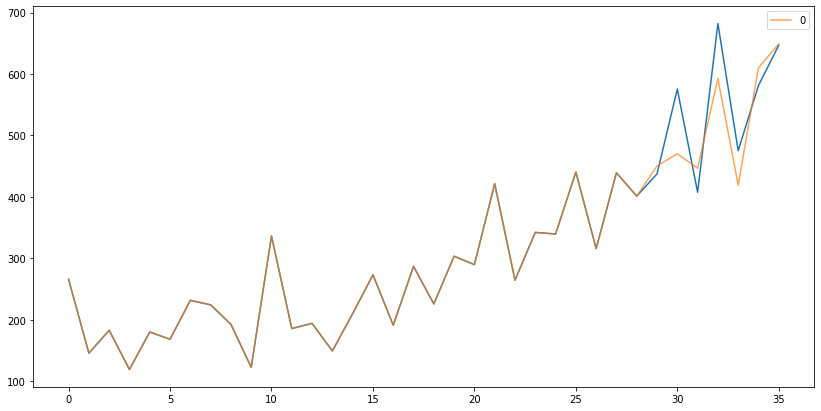

In [ ]:
history = [x for x in train]    
predictions = [ ]
cfg = [(0, 1, 2), (2, 0, 2, 0), 't']
for i in range(len(test)):
    pred_y = sarima_forecast(history, cfg)
    predictions.append(pred_y)
    history.append(test[i])

error = metrica_rmse(test, predictions)
print(f'rmse: {error}')
display(df_shampoo['Sales'], train, predictions)

##  Exponential Smoothing 

[ExponentialSmoothing](https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html)

`from statsmodels.tsa.holtwinters import ExponentialSmoothing`

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
def exp_smoothing_configs(seasonal=[None]): 
    models = list()
    # define lista de config 
    t_params = ['add', 'mul', None]
    d_params = [True, False] 
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    # cria instanciade de config 
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            cfg = [t,d,s,p,b,r]
                            models.append(cfg)
    return models

model_configs_es = exp_smoothing_configs()

In [ ]:
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config

    # define model
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # faz a previsão de um passo
    pred_y = model_fit.predict(len(history), len(history))
    return pred_y[0]

# walk-forward validação
def walk_forward_validation_es(data_train, data_test, cfg):
    predictions = []
    history = [x for x in data_train]
    error = 0
    try:
      # para cada etapa do conjunto de teste
      for i in range(len(data_test)):
        pred_y = exp_smoothing_forecast(history, cfg)
        predictions.append(pred_y)
        history.append(data_test[i])

    except:
      error = None
      predictions = None
    if error != None:
      error = metrica_rmse(data_test, predictions)
      
    print(f"config: {str(cfg)}, rsme: {error}")
    return (str(cfg), error, predictions)

def grid_search(data_train, cfg_list, data_test, parallel=False):
    scores = None
    if parallel:
        # executa configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing') 
        tasks = (delayed(walk_forward_validation_es)(data_train, data_test, cfg) for cfg in cfg_list) 
        scores = executor(tasks)
    else:
        scores = [walk_forward_validation_es(data_train, data_test, cfg) for cfg in cfg_list]
    # remove valores None
    scores = [r for r in scores if r[1] != None]

    # reordena por erro
    scores.sort(key=lambda tup: tup[1])

    print('done')
    # lista os top 3
    #for cfg, error, predictions in scores[:3]:
        #print(cfg, error)

    return scores[:3]

all_model_scores_es = grid_search(train, model_configs_es, test, parallel=False)


config: ['add', True, 'add', None, True, True], rsme: None
config: ['add', True, 'add', None, True, False], rsme: None
config: ['add', True, 'add', None, False, True], rsme: None
config: ['add', True, 'add', None, False, False], rsme: None
config: ['add', True, 'mul', None, True, True], rsme: None
config: ['add', True, 'mul', None, True, False], rsme: None
config: ['add', True, 'mul', None, False, True], rsme: None
config: ['add', True, 'mul', None, False, False], rsme: None
config: ['add', True, None, None, True, True], rsme: 114.17954227014654
config: ['add', True, None, None, True, False], rsme: 124.8178880307394
config: ['add', True, None, None, False, True], rsme: 114.39210236136171
config: ['add', True, None, None, False, False], rsme: 120.42544139035824
config: ['add', False, 'add', None, True, True], rsme: None
config: ['add', False, 'add', None, True, False], rsme: None
config: ['add', False, 'add', None, False, True], rsme: None
config: ['add', False, 'add', None, False, Fals

`all_model_scores_es`

**Parametro**: ['add', True, None, None, True, True] **RSME**: 114.17954227014654

**Parametro**: [None, False, None, None, True, True] **RSME**: 114.20852072415921

**Parametro**: ['add', True, None, None, False, True] RSME: 114.39210236136171

rmse: 114.17954227014654


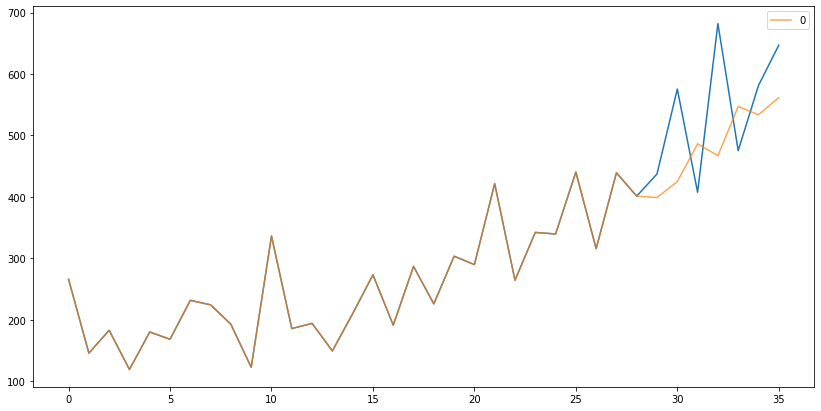

In [ ]:
history = [x for x in train]    
predictions = [ ]
cfg = ['add', True, None, None, True, True]
for i in range(len(test)):
    pred_y = exp_smoothing_forecast(history, cfg)
    predictions.append(pred_y)
    history.append(test[i])

error = metrica_rmse(test, predictions)
print(f'rmse: {error}')
display(df_shampoo['Sales'], train, predictions)